In [1]:
%matplotlib inline
import numpy as np
from cycler import cycler
import matplotlib
from matplotlib import pyplot, cm
from matplotlib.colors import colorConverter
import time
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB", "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
from freud import parallel
parallel.setNumThreads(4)
from scipy.ndimage.filters import gaussian_filter

from ipywidgets import IntProgress
from IPython.display import display

matplotlib.rcParams.update({'font.sans-serif': 'Helvetica'})
matplotlib.rcParams.update({'font.family': 'sans-serif'})
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.labelsize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'savefig.pad_inches': 0.025})
matplotlib.rcParams.update({"axes.prop_cycle": cycler(color=myColorCycle)})
matplotlib.rcParams.update({"lines.linewidth": 2})

# Potential of Mean Force and Torque (PMFT)

TODO: UPDATE

The RDF returns the probability of finding a particle centered at distance \\(r\\) from another particle in the system, relative to the ideal gas probability. The RDF is a relatively straightforward quantity to compute in simulations, and can be used to derive relevant thermodynamic quantities (those derivations will not be described or explained here). The basic algorithm is described below:

~~~
for each particle i:
    for each particle j:
        v_ij = position[j] - position[i]
        bin_ij = convert_to_bin(v_ij)
        pcf_array[bin_ij]++
~~~

Freud uses cell lists and parallelism to optimize this algorithm. An example for computing and viewing is shown below

time to calc 399 frames = 10.106068849563599
speed of calc: 39.48122716551943 (frames/sec)


/Users/harperic/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log
/Users/harperic/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


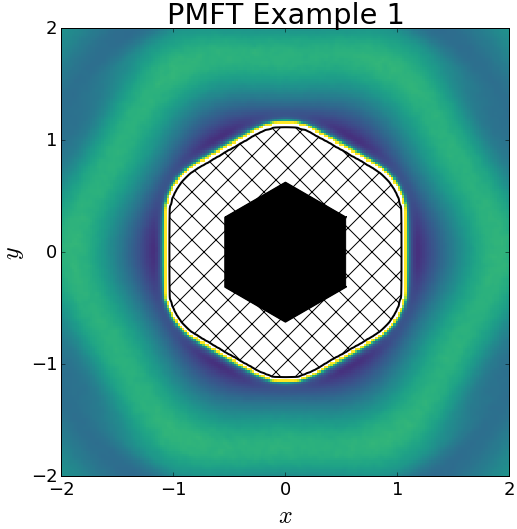

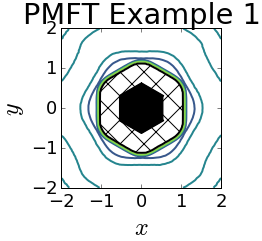

In [4]:
# import the freud object
# the rdf module is contained in the density module

from freud import box, pmft

verts = [[0.537284965911771, 0.31020161970069976],
  [3.7988742065678664e-17, 0.6204032394013997],
  [-0.5372849659117709, 0.31020161970070004],
  [-0.5372849659117711, -0.31020161970069976],
  [-1.1396622619703597e-16, -0.6204032394013997],
  [0.5372849659117711, -0.3102016197006997]]
verts = np.array(verts)

# create the rdf object
pmft = pmft.PMFTXY2D(x_max=3.0, y_max=3.0, n_x=300, n_y=300)

# load the data
data_path = "ex_data/phi065"
box_data = np.load("{}/box_data.npy".format(data_path))
pos_data = np.load("{}/pos_data.npy".format(data_path))
quat_data = np.load("{}/quat_data.npy".format(data_path))
n_frames = pos_data.shape[0]

myProgressBar = IntProgress(min=1,max=n_frames)
display(myProgressBar)

start_time = time.time()
for i in range(1, n_frames):
    # read box, position data
    myProgressBar.value = i
    l_box = box_data[i]
    l_pos = pos_data[i]
    l_quat = quat_data[i]
    l_ang = 2*np.arctan2(np.copy(l_quat[:,3]), np.copy(l_quat[:,0]))
    l_ang = l_ang % (2.0*np.pi)
    # create the freud box object
    fbox = box.Box(Lx=l_box["Lx"], Ly=l_box["Ly"], is2D=True)
    # accumulate
    pmft.accumulate(fbox, l_pos, l_ang, l_pos, l_ang)
stop_time = time.time()
print("time to calc {} frames = {}".format(n_frames-1, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((n_frames-1)/(stop_time-start_time)))

# get the value of the histogram bins
pmft_arr = np.copy(pmft.getPMFT())
# this will work, but I will need two copies, one for img, one for contour
# and...that will be a bit weird since the contours won't show up on the image...so choose?
# the image will hide the sins of the gaussian and sampling better...probably...
pmft_arr[np.isinf(pmft_arr)] = np.nan
dx = (2.0 * 3.0) / pmft.getNBinsX()
dy = (2.0 * 3.0) / pmft.getNBinsY()
nan_arr = np.where(np.isnan(pmft_arr))
for i in range(pmft.getNBinsX()):
    x = -3.0 + dx * i
    for j in range(pmft.getNBinsY()):
        y = -3.0 + dy * j
        if ((x*x + y*y < 1.5) and (np.isnan(pmft_arr[j,i]))):
            pmft_arr[j, i] = 10.0
w = int(2.0 * pmft.getNBinsX() / (2.0 * 3.0))
center = int(pmft.getNBinsX()/2)
# get the center of the histogram bins
pmft_smooth = gaussian_filter(pmft_arr, 1)
pmft_image = np.copy(pmft_smooth)
pmft_image[nan_arr] = np.nan
pmft_smooth = pmft_smooth[center-w:center+w, center-w:center+w]
pmft_image = pmft_image[center-w:center+w, center-w:center+w]
x = pmft.getX()
y = pmft.getY()
reduced_x = x[center-w:center+w]
reduced_y = y[center-w:center+w]

pyplot.figure(figsize=(8,8))
pyplot.title("PMFT Example 1")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
pyplot.imshow(np.flipud(pmft_image), extent=[-2,2,-2,2], interpolation="nearest", cmap="viridis", vmin=-2.5, vmax=3.0)
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
pyplot.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
pyplot.plot(verts[:,0], verts[:,1], color="black", marker=",")
pyplot.fill(verts[:,0], verts[:,1], color="black")
pyplot.axes().set_aspect("equal")
pyplot.xticks([i for i in range(-2, 3, 1)])
pyplot.yticks([i for i in range(-2, 3, 1)])
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.tight_layout()
pyplot.show()

pyplot.figure(figsize=(8,8))
pyplot.title("PMFT Example 1")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [-2, -1, 0, 2],
    colors=colors)
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
pyplot.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
pyplot.plot(verts[:,0], verts[:,1], color="black", marker=",")
pyplot.fill(verts[:,0], verts[:,1], color="black")
pyplot.axes().set_aspect("equal")
pyplot.xticks([i for i in range(-2, 3, 1)])
pyplot.yticks([i for i in range(-2, 3, 1)])
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.tight_layout()
pyplot.show()

time to calc 399 frames = 10.258994102478027
speed of calc: 38.89270195638604 (frames/sec)


/Users/harperic/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log
/Users/harperic/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


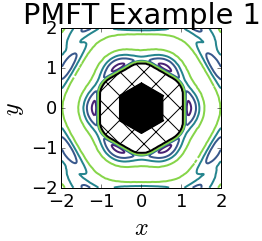

In [3]:
# import the freud object
# the rdf module is contained in the density module

from freud import box, pmft

verts = [[0.537284965911771, 0.31020161970069976],
  [3.7988742065678664e-17, 0.6204032394013997],
  [-0.5372849659117709, 0.31020161970070004],
  [-0.5372849659117711, -0.31020161970069976],
  [-1.1396622619703597e-16, -0.6204032394013997],
  [0.5372849659117711, -0.3102016197006997]]
verts = np.array(verts)

# create the rdf object
pmft = pmft.PMFTXY2D(x_max=3.0, y_max=3.0, n_x=300, n_y=300)

# load the data
data_path = "ex_data/phi075"
box_data = np.load("{}/box_data.npy".format(data_path))
pos_data = np.load("{}/pos_data.npy".format(data_path))
quat_data = np.load("{}/quat_data.npy".format(data_path))
n_frames = pos_data.shape[0]

myProgressBar = IntProgress(min=1,max=n_frames)
display(myProgressBar)

start_time = time.time()
for i in range(1, n_frames):
    # read box, position data
    myProgressBar.value = i
    l_box = box_data[i]
    l_pos = pos_data[i]
    l_quat = quat_data[i]
    l_ang = 2*np.arctan2(np.copy(l_quat[:,3]), np.copy(l_quat[:,0]))
    l_ang = l_ang % (2.0*np.pi)
    # create the freud box object
    fbox = box.Box(Lx=l_box["Lx"], Ly=l_box["Ly"], is2D=True)
    # accumulate
    pmft.accumulate(fbox, l_pos, l_ang, l_pos, l_ang)
stop_time = time.time()
print("time to calc {} frames = {}".format(n_frames-1, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((n_frames-1)/(stop_time-start_time)))

# get the value of the histogram bins
pmft_arr = np.copy(pmft.getPMFT())
# this will work, but I will need two copies, one for img, one for contour
# and...that will be a bit weird since the contours won't show up on the image...so choose?
# the image will hide the sins of the gaussian and sampling better...probably...
pmft_arr[np.isinf(pmft_arr)] = np.nan
dx = (2.0 * 3.0) / pmft.getNBinsX()
dy = (2.0 * 3.0) / pmft.getNBinsY()
for i in range(pmft.getNBinsX()):
    x = -3.0 + dx * i
    for j in range(pmft.getNBinsY()):
        y = -3.0 + dy * j
        if ((x*x + y*y < 1.5) and (np.isnan(pmft_arr[j,i]))):
            pmft_arr[j, i] = 10.0
w = int(2.0 * pmft.getNBinsX() / (2.0 * 3.0))
center = int(pmft.getNBinsX()/2)
# get the center of the histogram bins
pmft_reduced = np.array(pmft_arr[center-w:center+w, center-w:center+w])
pmft_smooth = gaussian_filter(pmft_reduced, 1)
x = pmft.getX()
y = pmft.getY()
reduced_x = x[center-w:center+w]
reduced_y = y[center-w:center+w]

pyplot.figure(figsize=(8,8))
pyplot.title("PMFT Example 1")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [-2, -1, 0, 2],
    colors=colors)
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
pyplot.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
pyplot.plot(verts[:,0], verts[:,1], color="black", marker=",")
pyplot.fill(verts[:,0], verts[:,1], color="black")
pyplot.axes().set_aspect("equal")
pyplot.xticks([i for i in range(-2, 3, 1)])
pyplot.yticks([i for i in range(-2, 3, 1)])
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.tight_layout()
pyplot.show()